# Implementation of Titsias' variational lower bound (VAR) with GPyTorch

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import torch
import gpytorch
from gpytorch import priors
from models.gpyt_sparse import TitsiasSparseGP, NystromSparseGP
from models.gpyt_regressor import MyGPModel

from gpytorch import likelihoods, mlls
import pandas as pd

## Simple dataset

In [3]:
df_train = pd.read_csv("simple_example/Simple_train.csv")
df_train

,X,Y
0,5.70,-0.454
1,1.39,-1.750
2,3.64,0.116
3,2.92,0.170
4,5.35,-1.080
...,...,...
195,1.15,-1.750
196,5.06,-0.889
197,1.04,-1.580
198,1.02,-1.100


In [4]:
X_train, y_train = torch.from_numpy(df_train['X'].values).float(), torch.from_numpy(df_train['Y'].values).float()

### Exact GP

In [5]:
def make_prediction(model, x_pred):
    """Return predictive distribution at points `x_pred`."""
    return regression_loss(model(x_pred))

Define the regression likelihood and model:

In [6]:
regression_loss = likelihoods.GaussianLikelihood()
model = MyGPModel(X_train, y_train, regression_loss)
model.train()
regression_loss.train()

hyp_loss = mlls.ExactMarginalLogLikelihood(regression_loss, model)

In [7]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

import tqdm
eprange = tqdm.notebook.tqdm_notebook(range(epochs))

losses_record = []

for i in eprange:
    output = model(X_train)
    loss = -hyp_loss(output, y_train)
    loss.backward()

    eprange.set_postfix({"mll": loss.data.item()})
    losses_record.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

In [8]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")

Text(0, 0.5, 'Loss')

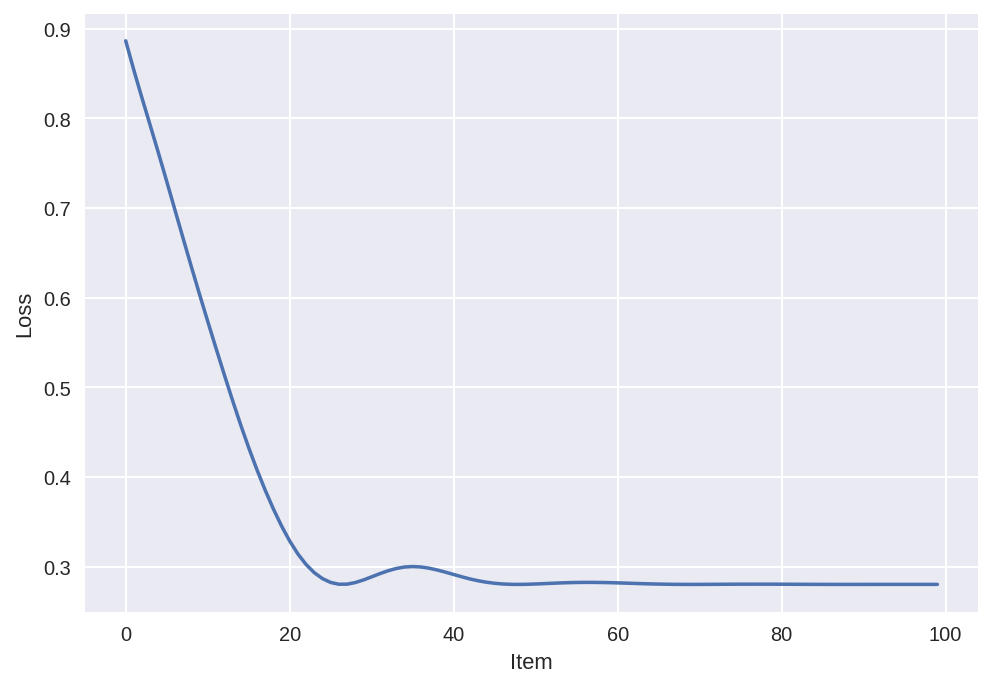

In [9]:
plt.plot(losses_record)
plt.xlabel("Item")
plt.ylabel("Loss")

In [10]:
dict(hyp_loss.named_hyperparameters())

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([-2.4802], requires_grad=True),
 'model.covar_module.raw_outputscale': Parameter containing:
 tensor(0.1438, requires_grad=True),
 'model.covar_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[-0.1694]], requires_grad=True)}

In [11]:
model.eval()
regression_loss.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [12]:
df_test = pd.read_csv("simple_example/Simple_test.csv")

In [13]:
X_test = torch.from_numpy(df_test['X'].values).float()
y_test = df_test['X'].values

In [14]:
y_pred_test = make_prediction(model, X_test)

In [15]:
y_pred_test.mean

tensor([ 2.9922e-06,  4.0633e-06,  5.9185e-06,  7.9548e-06,  1.0642e-05,
         1.5214e-05,  2.0144e-05,  2.6548e-05,  3.7245e-05,  4.8577e-05,
         6.3065e-05,  8.6821e-05,  1.1154e-04,  1.4263e-04,  1.9267e-04,
         2.4380e-04,  3.0704e-04,  4.0697e-04,  5.0720e-04,  6.2914e-04,
         8.1820e-04,  1.0043e-03,  1.2269e-03,  1.5655e-03,  1.8925e-03,
         2.2772e-03,  2.8510e-03,  3.3947e-03,  4.0234e-03,  4.9430e-03,
         5.7980e-03,  6.7690e-03,  8.1622e-03,  9.4319e-03,  1.0849e-02,
         1.2843e-02,  1.4622e-02,  1.6576e-02,  1.9266e-02,  2.1619e-02,
         2.4152e-02,  2.7568e-02,  3.0493e-02,  3.3578e-02,  3.7633e-02,
         4.1020e-02,  4.4502e-02,  4.8681e-02,  5.2541e-02,  5.6375e-02,
         6.0206e-02,  6.3782e-02,  6.7106e-02,  7.0128e-02,  7.2617e-02,
         7.4501e-02,  7.5658e-02,  7.5854e-02,  7.4955e-02,  7.2697e-02,
         6.9006e-02,  6.3566e-02,  5.6008e-02,  4.6392e-02,  3.4375e-02,
         1.9328e-02,  1.7079e-03, -1.9133e-02, -4.3

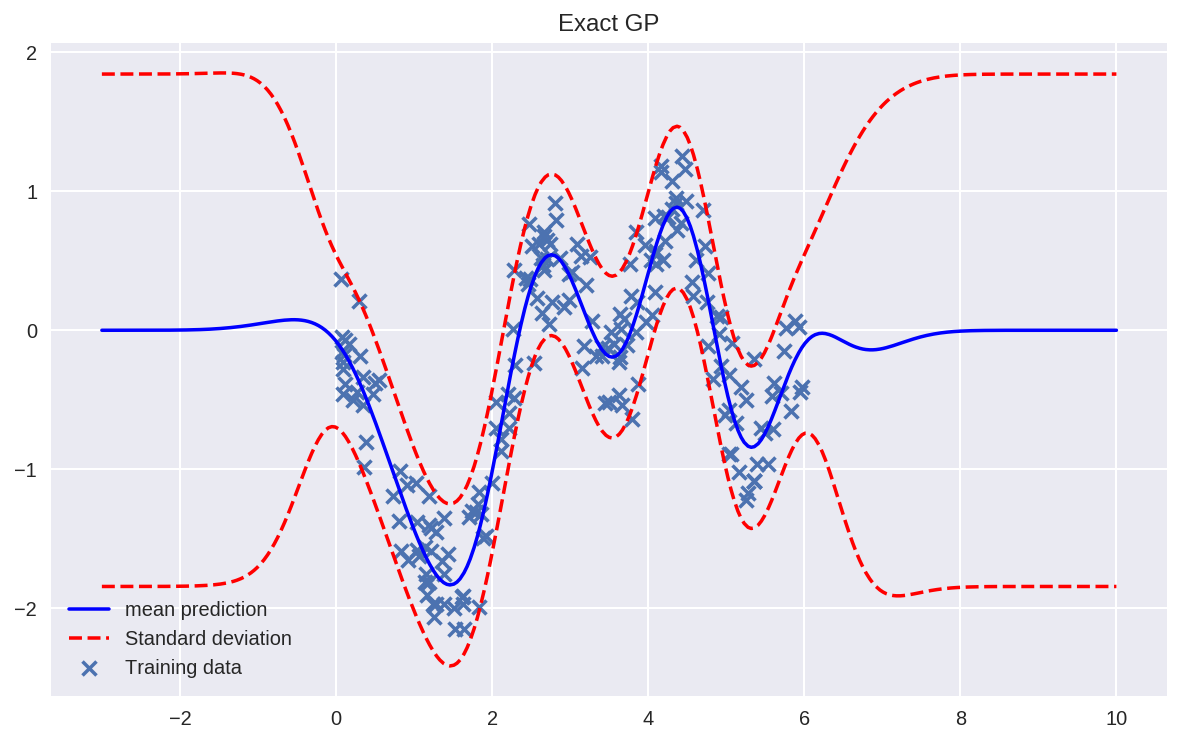

In [16]:
plt.figure(figsize=(10 , 6))
plt.scatter(X_train.data, y_train.data, marker = 'x' ,label = 'Training data')
plt.plot(X_test.data, y_pred_test.mean.data, 'b' , label = 'mean prediction')
lower, upper = y_pred_test.confidence_region()
lower.detach_()
upper.detach_()

plt.plot(X_test.data, lower, '--' ,  color='red' , label = 'Standard deviation')
plt.plot(X_test.data, upper, '--' , color='red')
min_lower_std = torch.min(lower) - 0.1
plt.title("Exact GP")
plt.legend()

### Titsias GP

In [32]:
import copy

In [33]:
regression_loss = likelihoods.GaussianLikelihood()
inducing_points = X_train[torch.multinomial(X_train, 10)]
inducing_points_prior = copy.deepcopy(inducing_points)
print(inducing_points_prior.shape)

# model = TitsiasSparseGP(X_train, y_train, inducing_points_prior, regression_loss)
model = NystromSparseGP(X_train, y_train, inducing_points_prior, regression_loss)
model.train()
regression_loss.train()

hyp_loss = mlls.ExactMarginalLogLikelihood(regression_loss, model)

torch.Size([10])


In [34]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

import tqdm
eprange = tqdm.notebook.tqdm_notebook(range(epochs))

losses_record = []

for i in eprange:
    output = model(X_train)
    loss = -hyp_loss(output, y_train)
    loss.backward()

    eprange.set_postfix({"mll": loss.data.item()})
    losses_record.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0, 0.5, 'Loss')

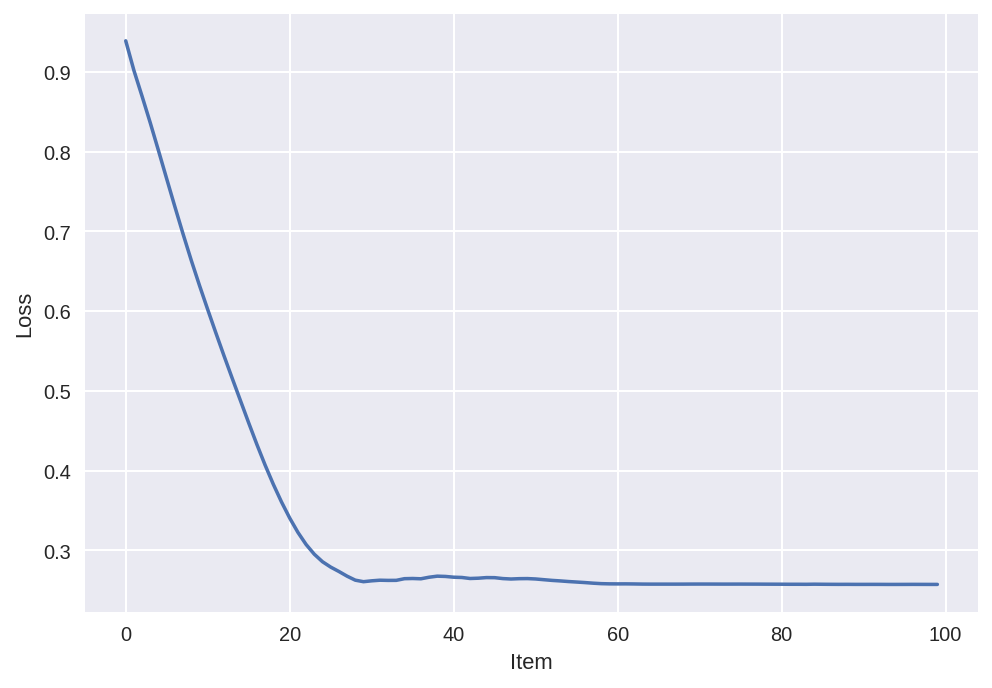

In [35]:
plt.plot(losses_record)
plt.xlabel("Item")
plt.ylabel("Loss")

In [36]:
dict(hyp_loss.named_hyperparameters())

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([-2.7724], requires_grad=True),
 'model.base_cov_module.raw_outputscale': Parameter containing:
 tensor(0.0538, requires_grad=True),
 'model.base_cov_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[-0.3552]], requires_grad=True),
 'model.covar_module.inducing_points': Parameter containing:
 tensor([[0.9262],
         [4.4581],
         [0.1340],
         [5.7053],
         [1.9145],
         [4.6780],
         [2.7443],
         [1.5720],
         [3.4389],
         [4.7440]], requires_grad=True)}

In [37]:
df_test = pd.read_csv("simple_example/Simple_test.csv")

In [38]:
X_test = torch.from_numpy(df_test['X'].values).float()
y_test = df_test['X'].values

In [39]:
model.eval()
regression_loss.eval()

y_pred_test = make_prediction(model, X_test)

In [40]:
y_pred_test.mean

tensor([ 1.9916e-09,  3.0964e-09,  5.3331e-09,  8.1862e-09,  1.2495e-08,
         2.1029e-08,  3.1689e-08,  4.7483e-08,  7.8092e-08,  1.1553e-07,
         1.6993e-07,  2.7309e-07,  3.9659e-07,  5.7267e-07,  8.9923e-07,
         1.2819e-06,  1.8171e-06,  2.7879e-06,  3.9012e-06,  5.4279e-06,
         8.1362e-06,  1.1175e-05,  1.5260e-05,  2.2346e-05,  3.0122e-05,
         4.0370e-05,  5.7741e-05,  7.6377e-05,  1.0044e-04,  1.4028e-04,
         1.8205e-04,  2.3486e-04,  3.2021e-04,  4.0758e-04,  5.1565e-04,
         6.8594e-04,  8.5591e-04,  1.0614e-03,  1.3765e-03,  1.6827e-03,
         2.0435e-03,  2.5809e-03,  3.0873e-03,  3.6674e-03,  4.5022e-03,
         5.2607e-03,  6.0995e-03,  7.1830e-03,  8.2565e-03,  9.3915e-03,
         1.0590e-02,  1.1761e-02,  1.2885e-02,  1.3923e-02,  1.4752e-02,
         1.5304e-02,  1.5468e-02,  1.5105e-02,  1.4076e-02,  1.2160e-02,
         9.2548e-03,  5.1217e-03, -6.0755e-04, -7.9074e-03, -1.7136e-02,
        -2.8831e-02, -4.2716e-02, -5.9398e-02, -7.9

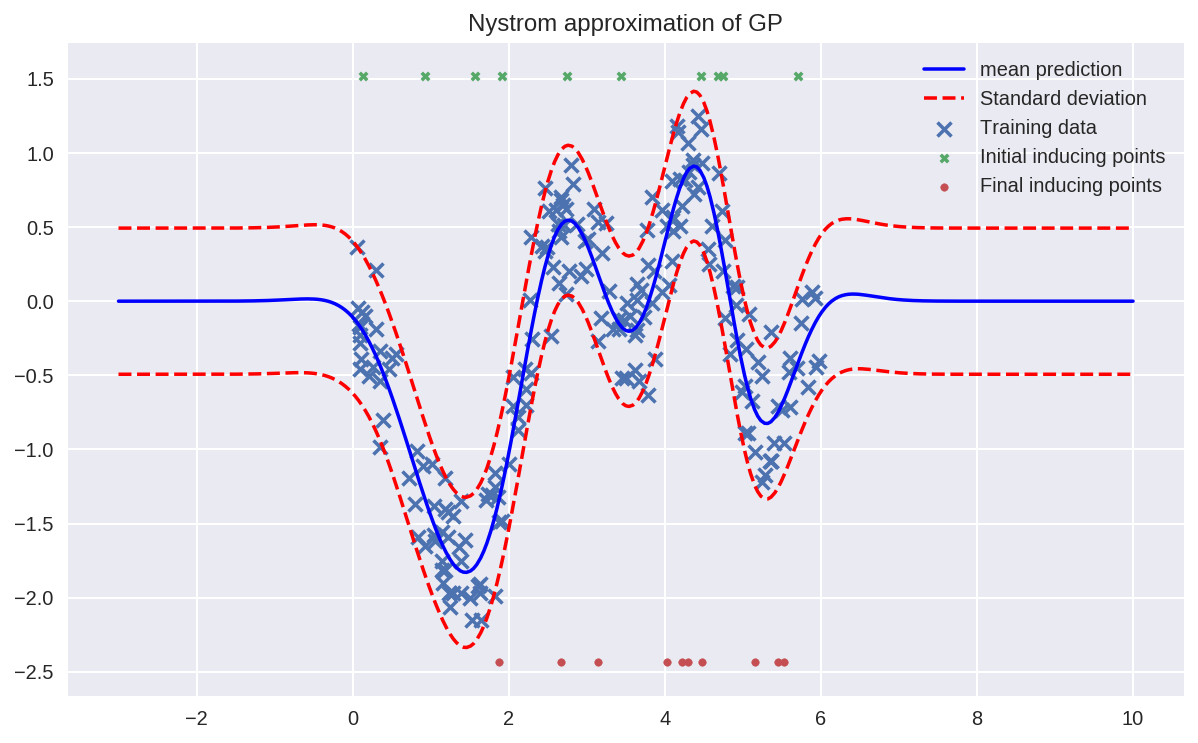

In [45]:
plt.figure(figsize=(10 , 6))
plt.scatter(X_train.data, y_train.data, marker = 'x' ,label = 'Training data')
plt.plot(X_test.data, y_pred_test.mean.data, 'b' , label = 'mean prediction')
lower, upper = y_pred_test.confidence_region()
lower.detach_()
upper.detach_()

plt.plot(X_test.data, lower, '--' ,  color='red' , label = 'Standard deviation')
plt.plot(X_test.data, upper, '--' , color='red')
min_lower_std = torch.min(lower) - 0.1
max_upper_std = torch.max(upper) + 0.1
plt.scatter(inducing_points_prior, max_upper_std*torch.ones_like(inducing_points_prior),
            s=14, marker="x", label="Initial inducing points")
plt.scatter(inducing_points, min_lower_std*torch.ones_like(inducing_points),
            s=14, marker="o", label="Final inducing points")
plt.title("Nystrom approximation of GP")
plt.legend()
